# Popularity Analysis

In [1]:
from google.cloud import bigquery
import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import math
pd.set_option('display.max_columns', 500)

## Preprocessing and feature extraction
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import datetime as dt
from sklearn.preprocessing import FunctionTransformer

## Models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
import timeit

## Model selection and fine tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import statsmodels.api as sm


# for model export
import joblib

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../BigQuery/letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()

In [2]:
%%bigquery track_genre
SELECT * FROM snappy-boulder-378707.TrackGenre.Trackgenre

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
track_genre

,track_id,Alternative,Blues,Cantopop,Classical,Dance Electronic,Folk & Acoustic,Hip-Hop,Indie,Instrumental,Jazz,K-Pop,Latin,Malay Pop,Mandopop,Metal,Musik Indonesia,Pop,R&B,Rock
0,001CyR8xqmmpVZFiTZJ5BC,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,001eyxfoYptAWzvF4ewLrR,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,002LxxV7VTy5JkvkmmGanl,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,002YdWxaenIUL4PHiv5EB5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,002nFT2kRsfvS0d17AwWsB,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74920,7zo6QXVQfHlycm8dsxkRGv,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74921,7zswEelYoepv2FYsDaGhUD,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74922,7zuKKxwcxaeGPrhKoNWdMP,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74923,7zyfphPnDBks6j6uIjttMR,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Import data

## Audio features

In [4]:
%%bigquery audio_feature
SELECT * FROM snappy-boulder-378707.AudioFeatures.AudioFeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
audio_feature.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature'],
      dtype='object')

In [6]:
audio_feature

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.556,0.7290,0,-5.907,0,0.0432,0.0331,0.015200,0.0907,0.1520,90.003,2LRqm962By8aNwJX0WxFNG,245204,4
1,0.825,0.1240,0,-11.175,0,0.0706,0.8000,0.000003,0.2430,0.2860,104.724,7rXQXbK4pQo8DSKlZ9ZSjC,230333,3
2,0.315,0.1020,0,-17.621,0,0.0340,0.9850,0.051200,0.1090,0.1850,169.690,0Oqxt6JixieLHbwMfnJGWO,206723,3
3,0.440,0.4970,1,-6.440,0,0.0402,0.0917,0.000000,0.2150,0.2090,73.541,6bBNc3V3PduYNL22lbed5R,156892,4
4,0.400,0.4710,1,-12.394,0,0.1610,0.8880,0.048000,0.1150,0.0385,84.481,5ZSqX1dDJ823Dndw94nogY,67804,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75026,0.881,0.0902,10,-13.818,1,0.1410,0.5470,0.897000,0.1360,0.3840,82.010,2hBSZIMfpkSayib4FO684h,117073,4
75027,0.881,0.6960,11,-3.838,0,0.0797,0.1370,0.000041,0.0927,0.7810,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4
75028,0.881,0.5230,11,-4.870,0,0.3380,0.1420,0.000000,0.0771,0.7500,96.506,6xrjmQMIIYgLgjCOeq2dee,211133,4
75029,0.881,0.3610,11,-14.728,0,0.2370,0.0502,0.004580,0.2460,0.7990,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4


## Tracks info

In [7]:
%%bigquery track_info
SELECT * FROM snappy-boulder-378707.TrackClearInfo.TrackClearInfo
WHERE popularity <> 0 and available_markets <> 0

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
track_info.head()

,id,name,album_id,artist_id,popularity,explicit,available_markets,extract_date
0,4feAlo2wgcAtOx6ED9jw2q,Face in the Crowd,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,36,0,134,2023-04-07
1,6f6jhTzxwvAYhzZrABTO8T,Weekends,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,34,1,134,2023-04-07
2,4xo2cd0kmp3GO1jZzAst1D,Can I Jump?,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,56,0,134,2023-04-07
3,6gVIrj4H3rmXYZnFXxtEl3,midnight rendezvous,4XAi7fxJkMgdqS73Wjte5J,4wkxDp8esk6g2W9Fw7IQGY,45,0,176,2023-04-07
4,2Wd0jIZnZI0gkze7ux0ZXs,Cut (Bendik HK Remix),3RtfM1haEzNzgmANkQPcLJ,0Q6X1jqwOVQuclYp2P1bub,4,0,179,2023-04-07


## Album info

In [9]:
%%bigquery release_date
SELECT id,release_date FROM snappy-boulder-378707.TrackClearInfo.AlbumInfo

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
release_date

,id,release_date
0,7rG4h8pLLcr6kW30cbSWD8,2023-04-07
1,2oRM1rJALdQfceK3i7SxG3,2023-03-24
2,4XAi7fxJkMgdqS73Wjte5J,2023-03-24
3,3RtfM1haEzNzgmANkQPcLJ,2023-03-31
4,22MkBC5l2Zi9atm66fE0Jq,2023-03-22
...,...,...
58130,4nvvfshb8jFXz5dmRL2zEe,2023-03-17
58131,0Z0dI0YMz5SgfXbElTztrs,2023-03-17
58132,65SUE4gUrSXcU2n02NldKN,2023-03-17
58133,2O1vg5NUciYqMXukzwvpIY,2023-03-17


## Artist_info

In [11]:
%%bigquery artist_info
SELECT distinct id, followers, popularity FROM `snappy-boulder-378707.TrackClearInfo.ArtistInfo`

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
artist_info

,id,followers,popularity
0,7oy3avikyzVHespBjOfjGQ,1,0
1,5Knvxyf7V57HhloqIWAGas,2,0
2,6bZ2pW1vt2NJ1XfP3Jwb29,48,0
3,5zuVGovDZ2VKZVuOiM7hCq,5,0
4,2eNMeOUJ4rZQ5uO6ie9hy0,48,0
...,...,...,...
28515,6VuMaDnrHyPL1p4EHjYLi7,19871695,83
28516,2o5jDhtHVPhrJdv3cEQ99Z,6818785,86
28517,7CajNmpbOovFoOoasH2HaY,23293100,87
28518,4MCBfE4596Uoi2O4DtmEMz,28507873,90


## Merge data

In [58]:
df = pd.merge(audio_feature, track_info, on="id", how="inner")
del df['extract_date']
df.drop_duplicates(inplace=True)

In [59]:
df = pd.merge(release_date, df, left_on="id", right_on="album_id",how="inner")
df.head()
df.drop_duplicates(inplace=True)

In [60]:
df= df.assign(artist_id=df.artist_id.str.split(";")).explode('artist_id')
df = pd.merge(df,artist_info, left_on="artist_id", right_on="id",how="inner")
df.head()
df.drop_duplicates(inplace=True)

In [61]:
df = df.groupby(['id_y','release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name',
       'popularity_x', 'explicit', 'available_markets'], as_index=False).aggregate({'followers':'mean','popularity_y':'mean'})

In [62]:
del df['id_y']

In [63]:
df.columns

Index(['release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name',
       'popularity_x', 'explicit', 'available_markets', 'followers',
       'popularity_y'],
      dtype='object')

In [64]:
df.columns = ['release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name', 'popularity_track', 'explicit',
       'available_markets','followers', 'popularity_artist']

In [65]:
df.drop_duplicates(inplace=True)

In [66]:
df

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,popularity_track,explicit,available_markets,followers,popularity_artist
0,2019-07-13,0.238,0.0132,2,-32.252,0,0.0375,0.9940,0.907000,0.0947,0.0410,67.773,224250,4,Desvelarse,35,0,184,325.0,50.0
1,2019-05-08,0.675,0.8290,6,-2.962,0,0.0455,0.1170,0.000844,0.2650,0.6940,108.914,212138,4,Venus 샛별,33,0,183,16378.0,27.0
2,2017-05-05,0.826,0.6790,1,-6.802,1,0.1290,0.3070,0.000025,0.1510,0.8410,90.048,160107,4,She Knows How To Rock Me,30,0,184,271037.0,54.5
3,1976-01-01,0.326,0.1810,0,-17.757,1,0.0473,0.9820,0.032700,0.1980,0.1440,135.032,602267,3,"Die Meistersinger von Nürnberg, WWV 96 / Act I...",22,0,184,159467.8,48.6
4,2022-03-18,0.385,0.1080,0,-21.476,1,0.0537,0.9690,0.107000,0.1080,0.0799,82.763,212827,3,This Foolish Heart Could Love You,42,0,183,322204.5,51.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62832,2018-11-02,0.551,0.8810,7,-6.099,0,0.0542,0.1860,0.079100,0.1520,0.3870,88.036,153000,4,You Get Me So High,80,0,184,12007614.0,85.0
62833,2010-01-01,0.542,0.6560,2,-4.471,0,0.0288,0.0236,0.000000,0.3030,0.2620,117.263,369040,4,Kau Dipaksa Aku Terpaksa,43,0,29,503.0,30.0
62834,2023-01-27,0.651,0.7200,9,-6.529,1,0.1610,0.3310,0.413000,0.5280,0.7050,90.024,269245,4,running out of time,67,0,183,8870042.0,80.0
62835,2014-12-19,0.423,0.3600,3,-9.458,1,0.0372,0.7280,0.000000,0.1050,0.2910,130.576,260573,4,以後別做朋友,60,0,184,1224310.0,67.0


# Data Transformation & Preprocessing

In [22]:
numeric_columns = ['danceability', 'energy', 'loudness', 
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 
       'popularity_track',  'available_markets','followers','popularity_artist']
catego_columns = ['mode','explicit','key', 'time_signature']

In [23]:
imputer_numeric = SimpleImputer(strategy='mean', missing_values=np.nan)
df[numeric_columns] = imputer_numeric.fit_transform(df[numeric_columns])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
df[['mode','explicit','key']] = imputer_catego.fit_transform(df[['mode','explicit','key']])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=4)
df[['time_signature']] = imputer_catego.fit_transform(df[['time_signature']])

In [24]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_track,explicit,available_markets,followers,popularity_artist
count,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,6.283700e+04,62837.000000,62837.000000,62837.000000,62837.000000,6.283700e+04,62837.000000
mean,0.558198,0.524412,5.238570,-10.193798,0.646434,0.072923,0.434445,0.234545,0.170148,0.429467,118.262838,2.292971e+05,3.886023,40.680825,0.085984,175.805035,2.182322e+06,51.094986
std,0.181739,0.279645,3.543646,6.833567,0.478080,0.077004,0.363059,0.367875,0.135772,0.253652,30.631754,9.569073e+04,0.435211,16.632551,0.280343,33.520675,7.160764e+06,18.981878
min,0.000000,0.000097,0.000000,-47.070000,0.000000,0.000000,0.000000,0.000000,0.007240,0.000000,0.000000,1.594900e+04,0.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000
25%,0.440000,0.305000,2.000000,-12.523000,0.000000,0.034700,0.065700,0.000000,0.096700,0.217000,94.005000,1.790770e+05,4.000000,29.000000,0.000000,183.000000,1.015400e+04,39.000000
50%,0.574000,0.545000,5.000000,-8.042000,1.000000,0.044400,0.372000,0.000303,0.116000,0.400000,118.144000,2.156670e+05,4.000000,40.000000,0.000000,184.000000,1.478730e+05,52.000000
75%,0.694000,0.759000,8.000000,-5.544000,1.000000,0.071900,0.802000,0.531000,0.191000,0.628000,137.966000,2.589200e+05,4.000000,52.000000,0.000000,185.000000,1.091512e+06,64.333333
max,0.984000,1.000000,11.000000,0.878000,1.000000,0.960000,0.996000,0.997000,1.000000,0.984000,237.488000,4.170227e+06,5.000000,100.000000,1.000000,185.000000,1.107113e+08,100.000000


## EDA

### Distribution of variables

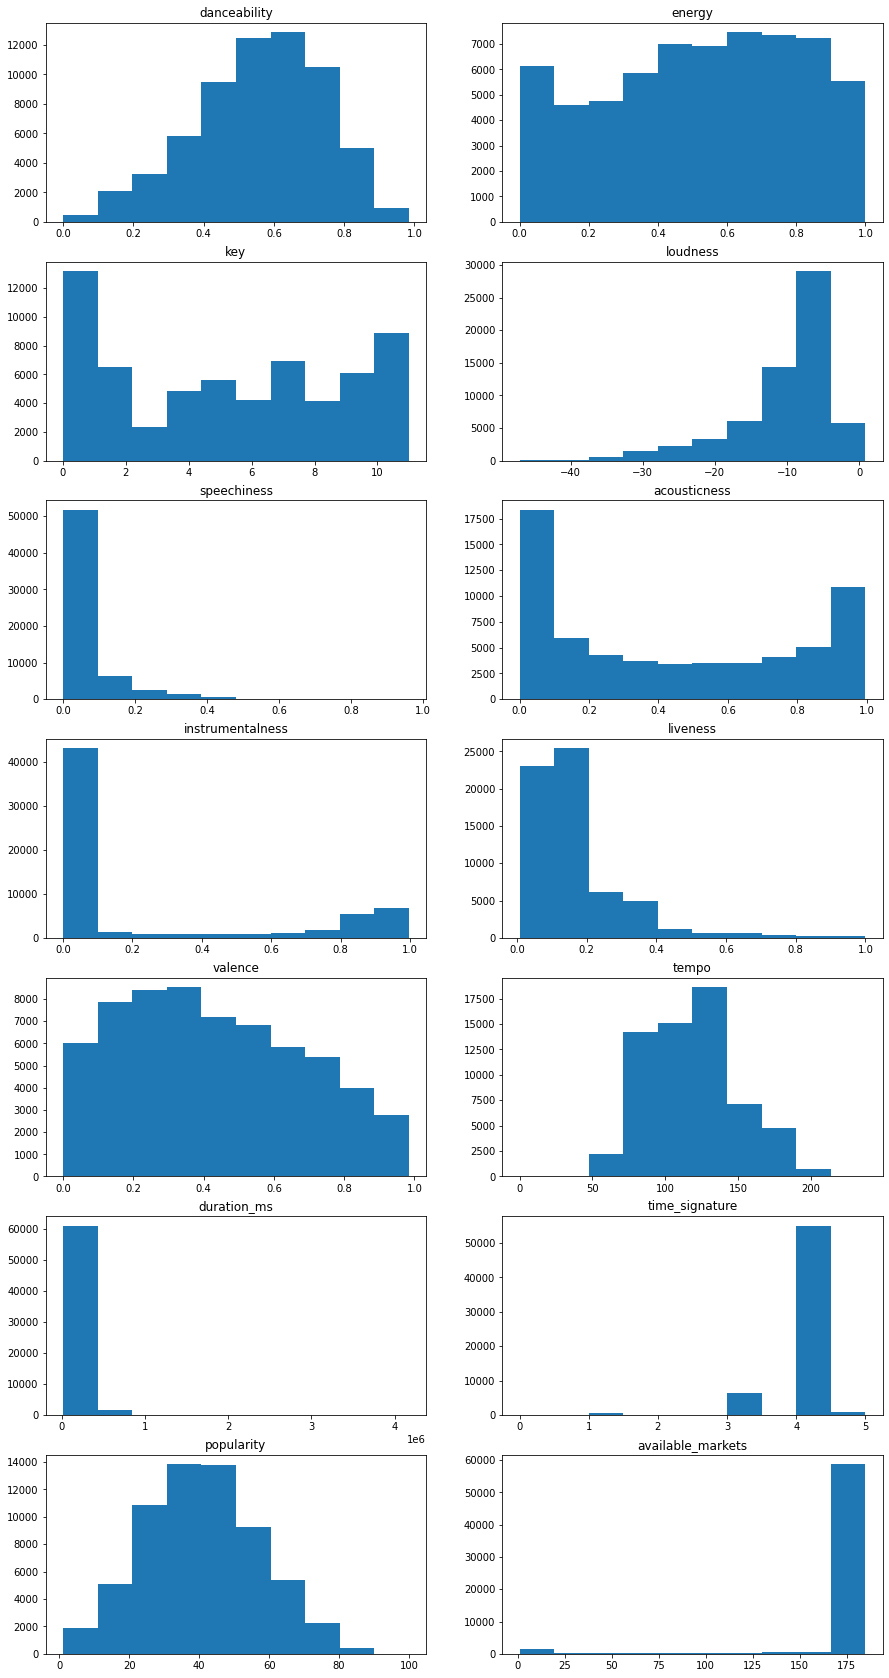

In [25]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2,figsize=(15,30))
ax1.hist(df[['danceability']])
ax2.hist(df[['energy']])
ax3.hist(df[['key']])
ax4.hist(df[['loudness']])
ax5.hist(df[['speechiness']])
ax6.hist(df[['acousticness']])
ax7.hist(df[['instrumentalness']])
ax8.hist(df[['liveness']])
ax9.hist(df[['valence']])
ax10.hist(df[['tempo']])
ax11.hist(df[['duration_ms']])
ax12.hist(df[['time_signature']])
ax13.hist(df[['popularity_track']])
ax14.hist(df[['available_markets']])

ax1.title.set_text('danceability')
ax2.title.set_text('energy')
ax3.title.set_text('key')
ax4.title.set_text('loudness')
ax5.title.set_text('speechiness')
ax6.title.set_text('acousticness')
ax7.title.set_text('instrumentalness')
ax8.title.set_text('liveness')
ax9.title.set_text('valence')
ax10.title.set_text('tempo')
ax11.title.set_text('duration_ms')
ax12.title.set_text('time_signature')
ax13.title.set_text('popularity')
ax14.title.set_text('available_markets')

Text(0, 0.5, 'frequency')

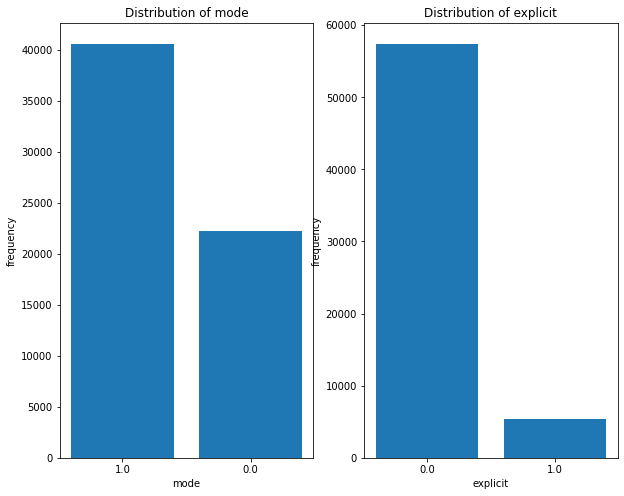

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
ax[0].bar(    
    x=list(map(str,df[catego_columns[0]].value_counts().keys().tolist())),
    height=df[catego_columns[0]].value_counts().values
    )
ax[0].set_title("Distribution of mode")
ax[0].set_xlabel("mode")
ax[0].set_ylabel("frequency")
ax[1].bar(    
    x=list(map(str,df[catego_columns[1]].value_counts().keys().tolist())),
    height=df[catego_columns[1]].value_counts().values
    )
ax[1].set_title("Distribution of explicit")
ax[1].set_xlabel("explicit")
ax[1].set_ylabel("frequency")

Text(0.5, 1.0, 'Popularity Based on Time Signature')

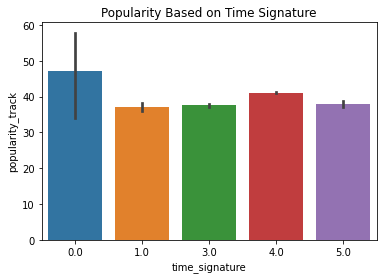

In [27]:
sns.barplot(x = 'time_signature', y = 'popularity_track', data = df)
plt.title('Popularity Based on Time Signature')

Text(0.5, 1.0, 'Popularity Based on Key')

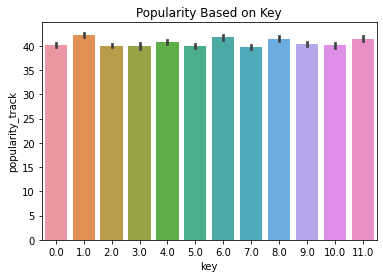

In [28]:
sns.barplot(x = 'key', y = 'popularity_track', data = df)
plt.title('Popularity Based on Key')

Text(0.5, 1.0, 'Popularity Based on Mode')

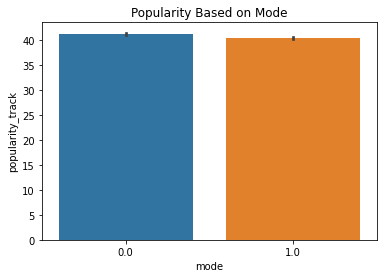

In [29]:
sns.barplot(x = 'mode', y = 'popularity_track', data = df)
plt.title('Popularity Based on Mode')

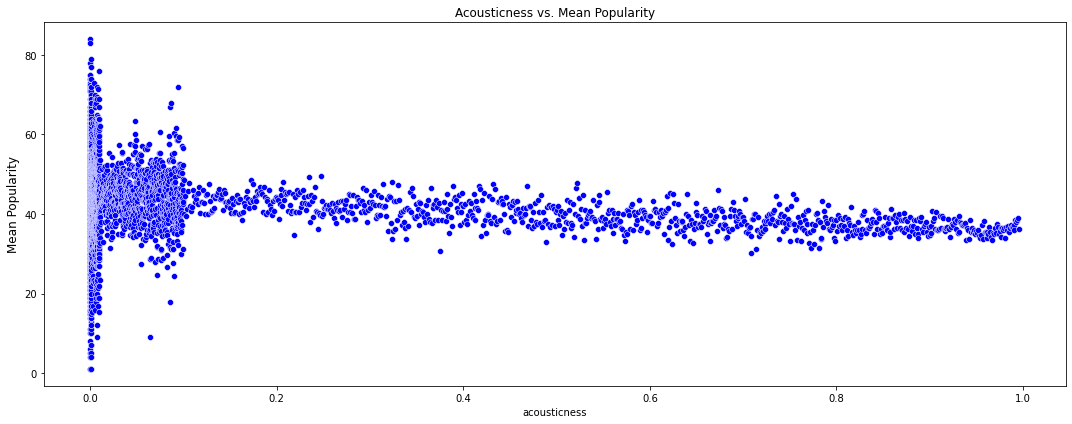

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('acousticness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['acousticness'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Acousticness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

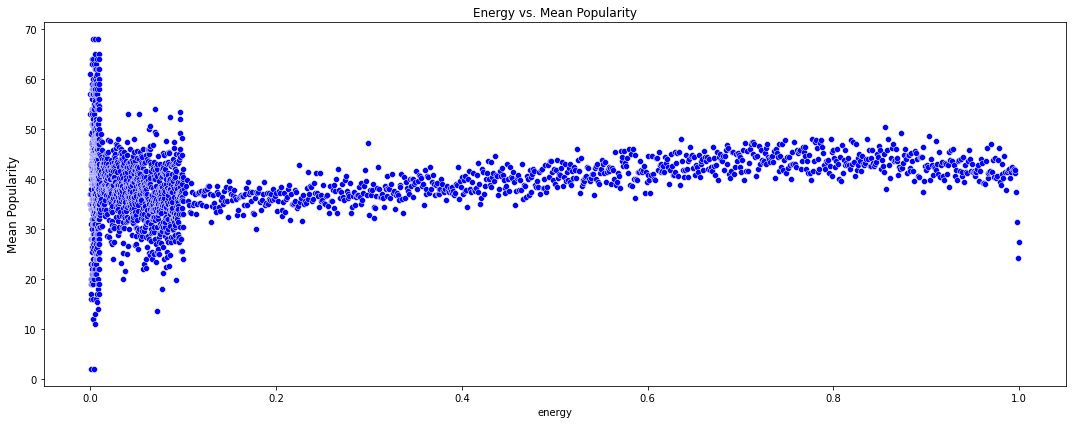

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('energy')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['energy'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Energy vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

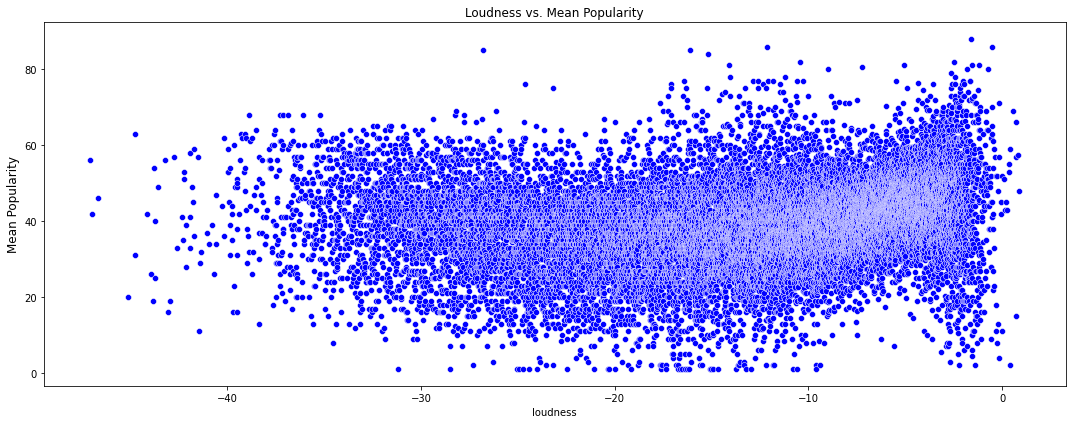

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('loudness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['loudness'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Loudness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

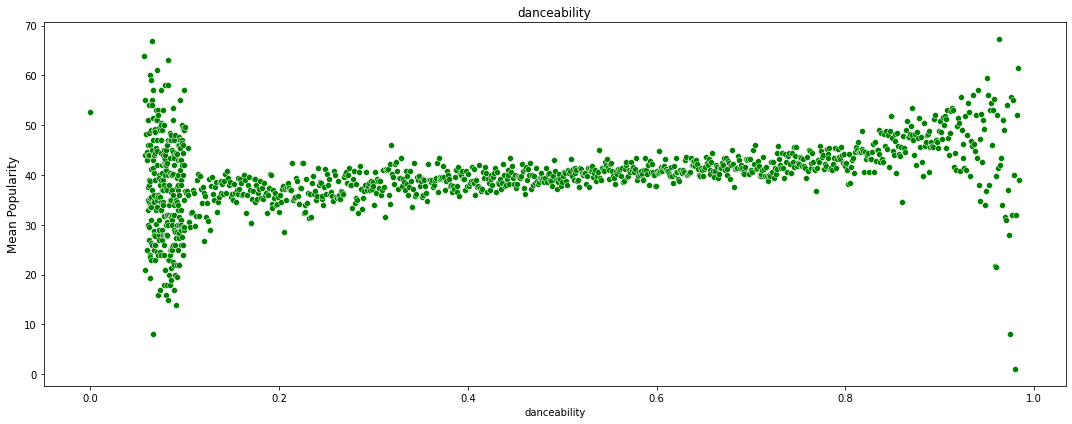

In [33]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('danceability')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='danceability', y='popularity_track', data=ax_data, color='green', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

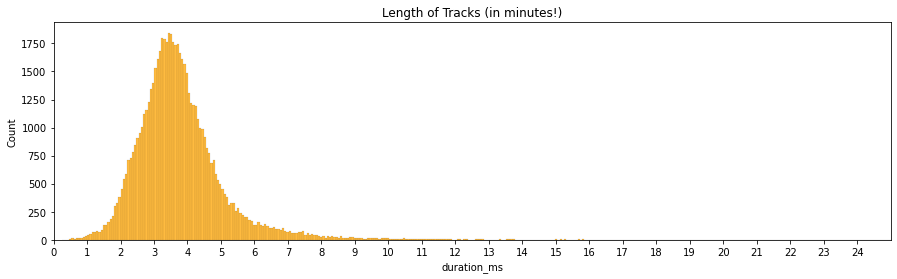

In [34]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.histplot(df['duration_ms']/60000, color='orange')
ax.set_title('Length of Tracks (in minutes!)')
ax.set_xticks(range(0,25,1))
ax.set_xlim(0,25)
plt.show()

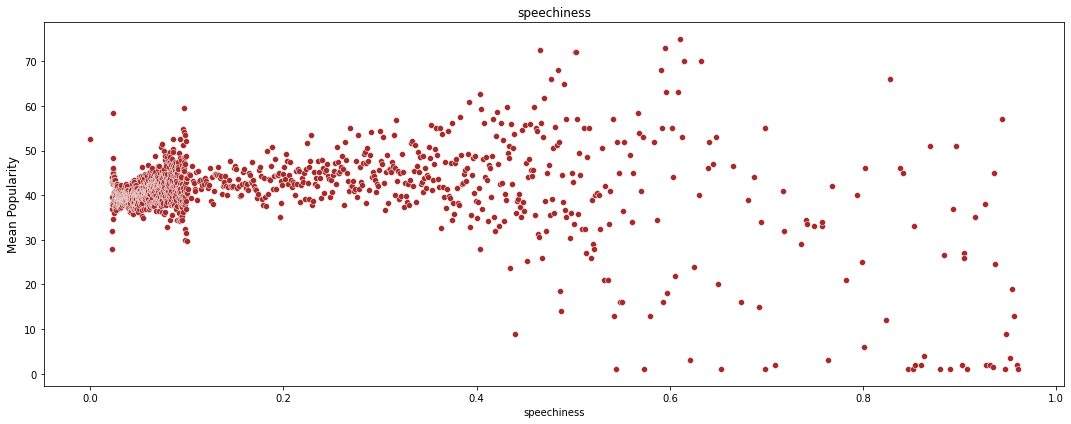

In [35]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('speechiness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='speechiness', y='popularity_track', data=ax_data, color='brown', ax=ax)
# ax.axvline(x=0.57, ymin=0, ymax=1, color='red', linestyle='dashed')
ax.set_title('speechiness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

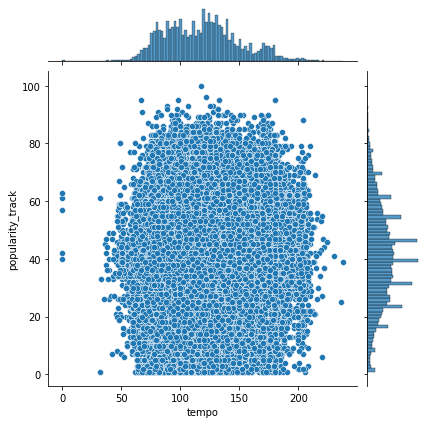

In [37]:
sns.jointplot(x='tempo', y='popularity_track', data=df)
plt.show()

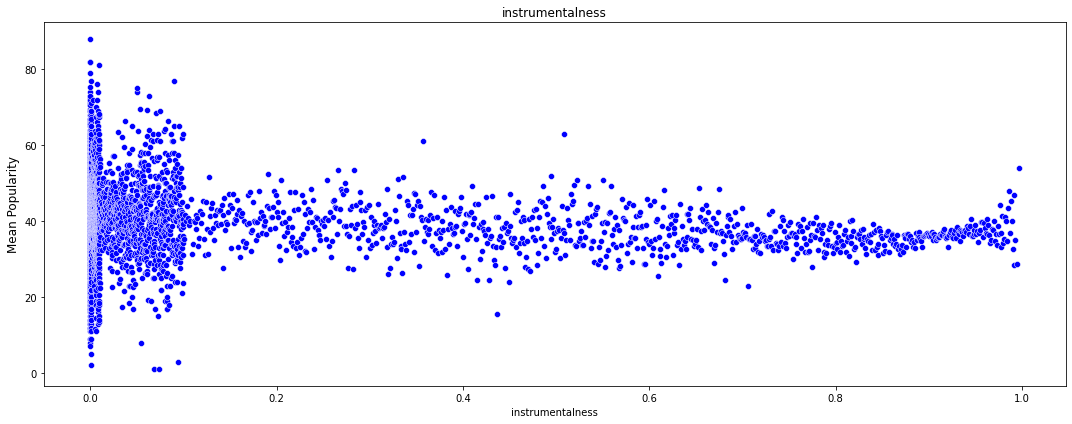

In [38]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('instrumentalness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='instrumentalness', y='popularity_track', data=ax_data, color='blue', ax=ax)
ax.set_title('instrumentalness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

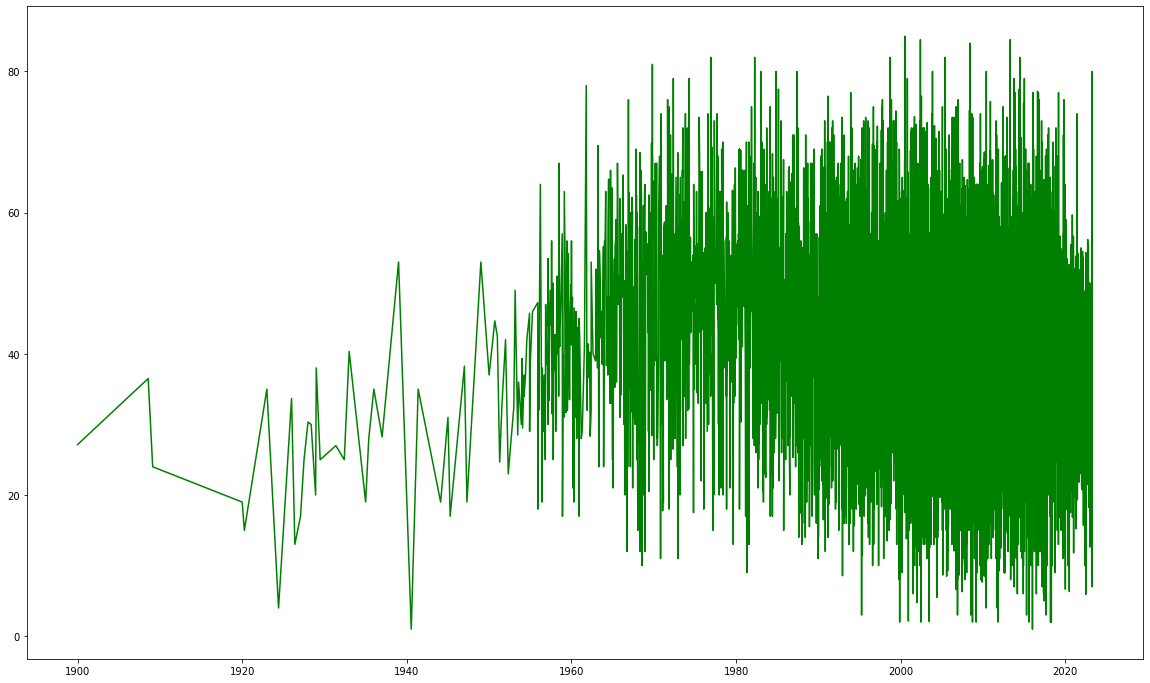

In [40]:
date_with_mean_pop = df.groupby('release_date')['popularity_track'].mean().to_frame().reset_index()
plt.figure(figsize=(20,12))
plt.plot_date(date_with_mean_pop[['release_date']],date_with_mean_pop[['popularity_track']], 'g')

## Correlation between features

<Axes: >

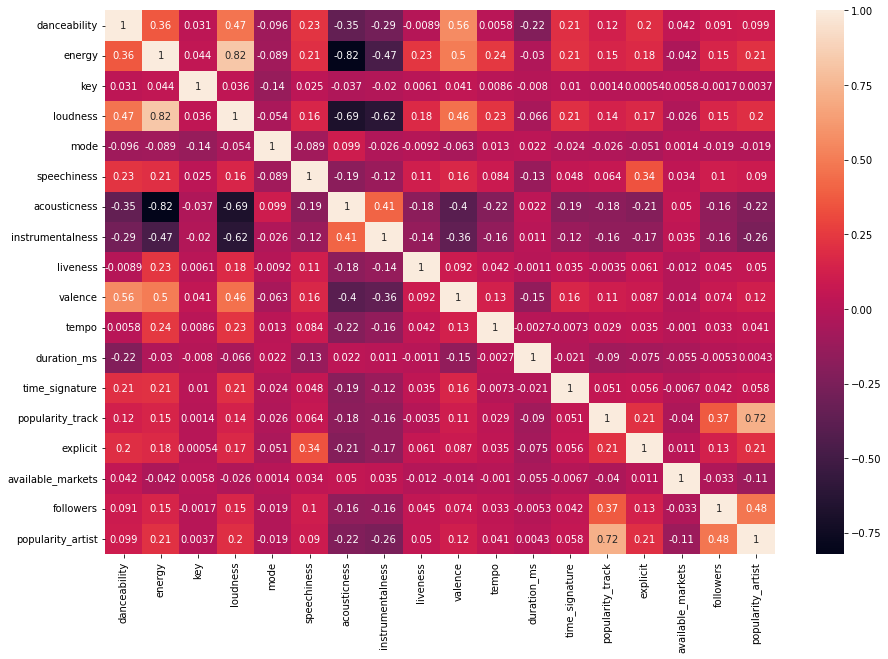

In [67]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

# Model Buiding

In [120]:
df.head()

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,popularity_track,explicit,available_markets,followers,popularity_artist
0,2019-07-13,0.238,0.0132,2,-32.252,0,0.0375,0.994,0.907000,0.0947,0.0410,67.773,224250,4,Desvelarse,35,0,184,325.0,50.0
1,2019-05-08,0.675,0.8290,6,-2.962,0,0.0455,0.117,0.000844,0.2650,0.6940,108.914,212138,4,Venus 샛별,33,0,183,16378.0,27.0
2,2017-05-05,0.826,0.6790,1,-6.802,1,0.1290,0.307,0.000025,0.1510,0.8410,90.048,160107,4,She Knows How To Rock Me,30,0,184,271037.0,54.5
3,1976-01-01,0.326,0.1810,0,-17.757,1,0.0473,0.982,0.032700,0.1980,0.1440,135.032,602267,3,"Die Meistersinger von Nürnberg, WWV 96 / Act I...",22,0,184,159467.8,48.6
4,2022-03-18,0.385,0.1080,0,-21.476,1,0.0537,0.969,0.107000,0.1080,0.0799,82.763,212827,3,This Foolish Heart Could Love You,42,0,183,322204.5,51.5


First, we need to split the data.

If we consider the usecase of Spotify, the company certainly wants to predict the popularity of future songs. Thus, we should split the dataset between songs issued before a certain year and songs issued after it.

We will make a train set of all the songs previous to 2022-8-18, and a test set composed of the songs issued on and after 2022-8-18 (20% of the total dataset).

In [121]:
X = df.sort_values(by='release_date').drop(columns=['popularity_track','name']).copy()
y = df.sort_values(by='release_date')['popularity_track'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [122]:
X_train.tail(5)

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
35951,2022-08-18,0.853,0.422,8,-5.639,1,0.1130,0.00572,0.000003,0.1100,0.522,160.028,136981,4,1,183,82152.0,52.0
58019,2022-08-18,0.529,0.232,7,-12.981,0,0.0324,0.90600,0.897000,0.0893,0.276,171.888,118221,4,0,185,71.0,42.0
2874,2022-08-18,0.551,0.270,0,-11.512,0,0.0721,0.94300,0.855000,0.1100,0.137,160.038,132000,4,0,184,206.5,44.5
45614,2022-08-18,0.834,0.684,1,-7.453,1,0.0694,0.07490,0.000094,0.1920,0.641,98.015,222876,4,1,185,552730.5,70.0
34123,2022-08-18,0.748,0.427,9,-11.740,1,0.1020,0.37200,0.950000,0.1360,0.616,175.991,144545,4,0,184,73.0,23.0


In [123]:
X_train['release_date']=X_train['release_date'].map(dt.datetime.toordinal)
X_test['release_date']=X_test['release_date'].map(dt.datetime.toordinal)

In [124]:
X_train

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
20133,693596,0.570,0.324,3,-11.642,1,0.0499,0.94100,0.001660,0.1900,0.882,135.962,169627,4,0,181,19385.0,40.0
51407,693596,0.535,0.249,0,-12.238,0,0.0332,0.95200,0.079100,0.0905,0.823,93.297,194760,4,0,181,19385.0,40.0
24023,693596,0.577,0.303,0,-11.966,1,0.0416,0.95100,0.000000,0.2150,0.825,134.642,218867,4,0,181,19385.0,40.0
17652,693596,0.394,0.314,0,-11.151,0,0.0323,0.84700,0.007210,0.1680,0.520,71.110,151133,4,0,181,19385.0,40.0
46993,693596,0.550,0.290,10,-14.191,0,0.0280,0.88100,0.000076,0.1630,0.427,91.583,191467,4,0,181,19385.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35951,738385,0.853,0.422,8,-5.639,1,0.1130,0.00572,0.000003,0.1100,0.522,160.028,136981,4,1,183,82152.0,52.0
58019,738385,0.529,0.232,7,-12.981,0,0.0324,0.90600,0.897000,0.0893,0.276,171.888,118221,4,0,185,71.0,42.0
2874,738385,0.551,0.270,0,-11.512,0,0.0721,0.94300,0.855000,0.1100,0.137,160.038,132000,4,0,184,206.5,44.5
45614,738385,0.834,0.684,1,-7.453,1,0.0694,0.07490,0.000094,0.1920,0.641,98.015,222876,4,1,185,552730.5,70.0


In [125]:
y_train.tail(5)

35951    41
58019    38
2874     34
45614    64
34123    29
Name: popularity_track, dtype: Int64

In [127]:
ct = ColumnTransformer([('minmax', MinMaxScaler(), ['release_date','loudness', 'tempo', 'duration_ms','available_markets','followers','popularity_artist']),
                        ('categorical', OneHotEncoder(handle_unknown = 'ignore'), ['key','mode','time_signature','explicit']),
                       ],
                       remainder='passthrough')

ct.fit(X_train)
joblib.dump(ct, 'Popularity Prediction Data Preprocess.sav')

X_train_preprocessed = pd.DataFrame(ct.transform(X_train))
X_test_preprocessed = pd.DataFrame(ct.transform(X_test))

In [128]:
X_test_preprocessed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.000000,0.435367,0.344608,0.028817,0.994565,0.000011,0.420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.329,0.0998,0.0349,0.9930,0.940000,0.0892,0.2840
1,1.000000,0.854530,0.409542,0.037399,0.994565,0.032720,0.795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.790,0.5690,0.0867,0.3690,0.000000,0.1270,0.5630
2,1.000000,0.726683,0.594524,0.030439,0.989130,0.000026,0.330,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.265,0.4020,0.0423,0.4010,0.795000,0.1350,0.0405
3,1.000000,0.845478,0.571913,0.048069,1.000000,0.000868,0.490,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.324,0.4240,0.0309,0.5690,0.000000,0.1030,0.0759
4,1.000000,0.851339,0.747760,0.057229,0.989130,0.000280,0.380,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.342,0.4900,0.0434,0.7410,0.000000,0.0975,0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12563,1.005113,0.806624,0.411938,0.034435,0.994565,0.003286,0.540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.722,0.6130,0.0411,0.1190,0.083000,0.1120,0.3980
12564,1.005113,0.809314,0.774424,0.037004,0.994565,0.003286,0.540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.672,0.6800,0.0622,0.0286,0.558000,0.0929,0.8650
12565,1.005113,0.878347,0.699589,0.047643,0.994565,0.004799,0.580,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.621,0.8300,0.0350,0.1740,0.000004,0.0999,0.8370
12566,1.005135,0.707537,0.587576,0.071812,0.994565,0.004742,0.780,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.447,0.1600,0.0370,0.8800,0.000000,0.1110,0.2290


In [129]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [130]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [84]:
# verifictaion
nl = '\n'
print(f'X_train_preprocessed shape is: {X_train_preprocessed.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test_preprocessed shape is: {X_test_preprocessed.shape} {nl}y_test shape is: {y_test.shape}')

X_train_preprocessed shape is: (50269, 35) 
y_train shape is: (50269,) 
X_test_preprocessed shape is: (12568, 35) 
y_test shape is: (12568,)


### Linear Regression (selected features only (corr > 0.1))

In [85]:
X_train_preprocessed.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,0.0,0.738884,0.605524,0.036285,0.978261,0.000175,0.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.570,0.324,0.0499,0.941,0.00166,0.1900,0.882
1,0.0,0.726454,0.415510,0.042339,0.978261,0.000175,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.535,0.249,0.0332,0.952,0.07910,0.0905,0.823
2,0.0,0.732126,0.599645,0.048146,0.978261,0.000175,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.577,0.303,0.0416,0.951,0.00000,0.2150,0.825


In [86]:
X_train_preprocessed.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
count,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.00000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000
mean,0.909947,0.767353,0.526534,0.052532,0.942403,0.022156,0.524616,0.120571,0.089180,0.105791,0.036623,0.077801,0.090254,0.065070,0.111520,0.064473,0.097635,0.066701,0.074380,0.343751,0.656249,0.000119,0.00933,0.102628,0.873282,0.014641,0.926197,0.073803,0.550204,0.524053,0.069589,0.437086,0.217543,0.170183,0.433166
std,0.117470,0.145939,0.135278,0.023731,0.195884,0.068879,0.186191,0.325632,0.285007,0.307573,0.187836,0.267862,0.286549,0.246652,0.314778,0.245596,0.296823,0.249506,0.262391,0.474964,0.474964,0.010925,0.09614,0.303475,0.332660,0.120113,0.261453,0.261453,0.183928,0.282637,0.071718,0.363935,0.358102,0.136720,0.256762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000270,0.000000,0.000000,0.000000,0.007240,0.000000
25%,0.869522,0.718570,0.421393,0.040421,0.989130,0.000195,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.430000,0.301000,0.034300,0.067200,0.000000,0.095800,0.218000
50%,0.962044,0.814153,0.525644,0.048896,0.994565,0.001877,0.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.565000,0.546000,0.043400,0.376000,0.000201,0.116000,0.404000
75%,0.989395,0.866877,0.611822,0.059372,1.000000,0.012269,0.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.688000,0.762000,0.067800,0.806000,0.367000,0.192000,0.636000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.983000,1.000000,0.959000,0.996000,0.997000,1.000000,0.984000


In [98]:
LR = LinearRegression()
cols = [col for col in X_train_preprocessed.columns if abs(X_train_preprocessed[col].corr((y_train).astype(float)))>0.1]

# Fit the model and
LR.fit(X_train_preprocessed.drop(columns=cols), y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train_preprocessed.drop(columns=cols))
# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.5f}")

RMSE Train = 16.51312


In [99]:
#Predicting with the model
y_test_pred = LR.predict(X_test_preprocessed.drop(columns=cols))#.clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Val = {LR_rmse:.5f}")

RMSE Val = 16.44930


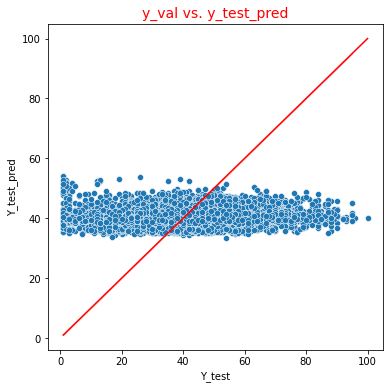

In [104]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test.astype(float), y=y_test.astype(float), color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_val vs. y_test_pred', fontsize=14, color='red')
plt.show()

### Linear Regression (all features)

In [105]:
# Count time
start_time = timeit.default_timer()
LR = LinearRegression()

# Fit the model and
LR.fit(X_train_preprocessed, y_train)
elapsed_1 = timeit.default_timer() - start_time

# Train Predicting with the model
y_train_pred2 = LR.predict(X_train_preprocessed)#.clip(0, 1)

# RMSE Train
LR_rmse2 = np.sqrt(mse(y_train, y_train_pred2))
print(f"RMSE Train = {LR_rmse2:.6f}")

RMSE Train = 11.649902


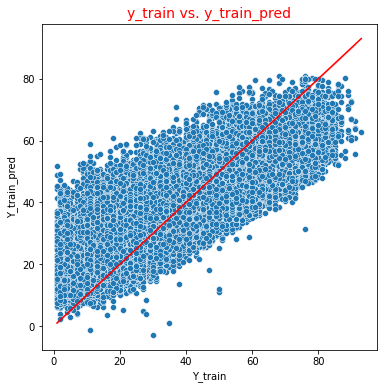

In [108]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_train, y=y_train_pred2)
sns.lineplot(x=y_train, y=y_train, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('Y_train_pred')
ax.set_title('y_train vs. y_train_pred', fontsize=14, color='red')
plt.show()

In [109]:
#Predicting with the model
start_time = timeit.default_timer()
y_test_pred = LR.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_1_predict = timeit.default_timer() - start_time

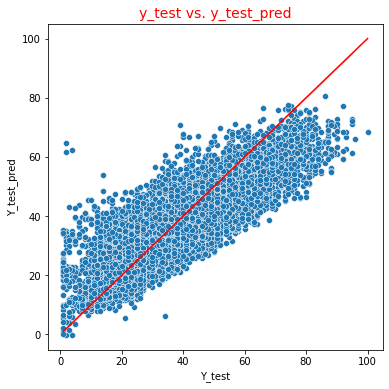

In [110]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [111]:
model = sm.OLS(list(y_train), X_train_preprocessed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1696.
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:05:21   Log-Likelihood:            -1.9475e+05
No. Observations:               50269   AIC:                         3.896e+05
Df Residuals:                   50237   BIC:                         3.899e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9520      0.482      1.974      0.048       0.007       1.897
1             -4.8324      0.778     -6.211      0.000      -6.357      -3.307
2              0.7555      0.404      1.868      0.062      -0.037       1.548
3            -57.5837      2.293    -25.118      0.000     -62.077     -53.090
4              2.2871      0.269      8.497      0.000       1.760       2.815
5             10.1632      0.871     11.665      0.000       8.455      11.871
6             60.6303      0.338    179.448      0.000      59.968      61.293
7              0.9859      0.167      5.897      0.000       0.658       1.314
8              1.1994      0.188      6.387      0.000       0.831       1.567
9              1.1302      0.174      6.486      0.000       0.789       1.472
10             1.5411      0.269      5.736      0.000       1.015       2.068
11             1.3946      0.196      7.132      0.000       1.011       1.778
12             0.5615      0.186      3.019      0.003       0.197       0.926
13             1.3674      0.211      6.472      0.000       0.953       1.781
14             0.8214      0.172      4.774      0.000       0.484       1.159
15             1.1942      0.212      5.643      0.000       0.779       1.609
16             1.3250      0.179      7.413      0.000       0.975       1.675
17             0.7059      0.208      3.390      0.001       0.298       1.114
18             1.1910      0.202      5.907      0.000       0.796       1.586
19             6.7483      0.485     13.928      0.000       5.799       7.698
20             6.6692      0.483     13.822      0.000       5.723       7.615
21             9.3096      3.961      2.350      0.019       1.546      17.073
22             1.1756      0.931      1.263      0.207      -0.649       3.000
23             0.5994      0.835      0.718      0.473      -1.038       2.237
24             1.0718      0.829      1.293      0.196      -0.553       2.697
25             1.2611      0.893      1.412      0.158      -0.490       3.012
26             4.4076      0.481      9.156      0.000       3.464       5.351
27             9.0099      0.504     17.885      0.000       8.023       9.997
28             1.7826      0.402      4.436      0.000       0.995       2.570
29            -1.7821      0.456     -3.904      0.000      -2.677      -0.887
30            -9.6845      0.810    -11.953      0.000     -11.273      -8.097
31            -2.1979      0.259     -8.479      0.000      -2.706      -1.690
32             1.0418      0.198      5.259      0.000       0.654       1.430
33            -4.4232      0.396    -11.173      0.000      -5.199      -3.647
34             1.7370      0.287      6.056      0.000       1.175       2.299
==============================================================================
Om

In [112]:
r2_lr = r2_score(y_test, y_test_pred)
LR_rmse2 = np.sqrt(mse(y_test, y_test_pred))
print("R-Squared = {:.6f}".format(round(r2_lr, 6)))
print('Run time = ', elapsed_1)
print(f"RMSE Test = {LR_rmse2:.6f}")

R-Squared = 0.636527
Run time =  0.10302311600003122
RMSE Test = 9.923519


### Lasso

In [89]:
# Count time
start_time = timeit.default_timer()
# Lasso
lasso=Lasso()
lasso_fit = lasso.fit(X_train_preprocessed,y_train)
elapsed_2 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
y_pred = lasso.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_2_predict = timeit.default_timer() - start_time
mean_squared_error(y_test, y_pred, squared=False)

11.831564378781858

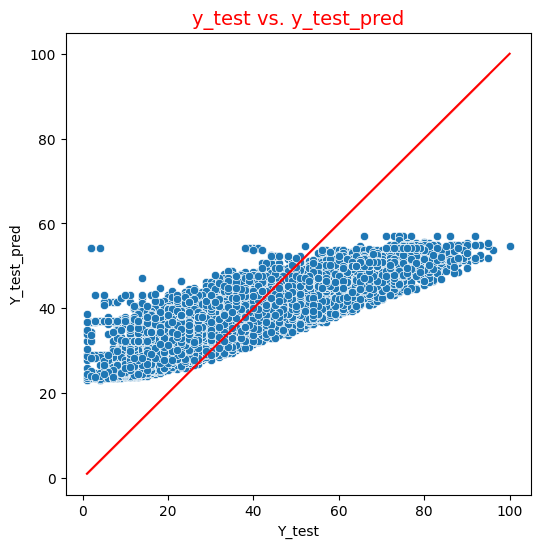

In [90]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [91]:
r2_lasso = r2_score(y_test, y_pred)
lasso_rmse = np.sqrt(mse(y_test, y_pred))
print('Run time = ', elapsed_2)
print(f"RMSE Test = {lasso_rmse:.6f}")

Run time =  0.02816926000014064
RMSE Test = 11.831564


### XGBoost Regression

In [92]:
# Count time
start_time = timeit.default_timer()
# XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=20, learning_rate=0.01)
xgb_fit = xgb_regressor.fit(X_train_preprocessed, y_train)
elapsed_3 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
y_pred_xg = xgb_regressor.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_3_predict = timeit.default_timer() - start_time
mean_squared_error(y_test, y_pred_xg, squared=False)

20.308771630213524

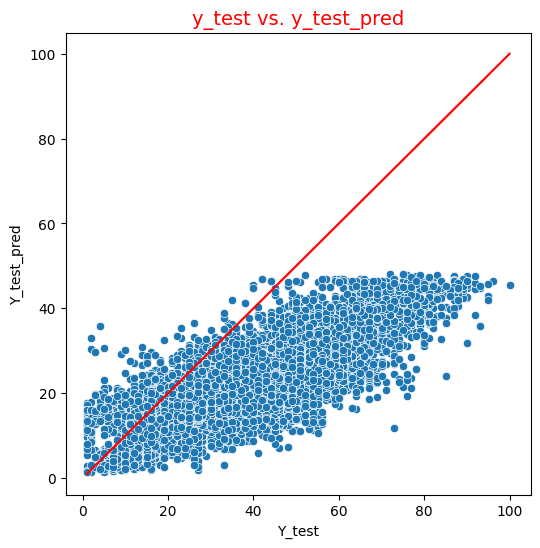

In [93]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_xg)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [94]:
xgboost_rmse = np.sqrt(mse(y_test, y_pred_xg))
print('Run time = ', elapsed_3)
print(f"RMSE Test = {xgboost_rmse:.6f}")

Run time =  20.708872737000092
RMSE Test = 20.308772


### K-Nearest-Neighbors (KNN) Regression

In [95]:
# Count time
start_time = timeit.default_timer()
# K-Nearest-Neighbors (KNN) regressor
neigh = KNeighborsRegressor(n_neighbors=7)

neigh_fit = neigh.fit(X_train_preprocessed, y_train)
elapsed_4 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
y_pred_kn=neigh.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_4_predict = timeit.default_timer() - start_time

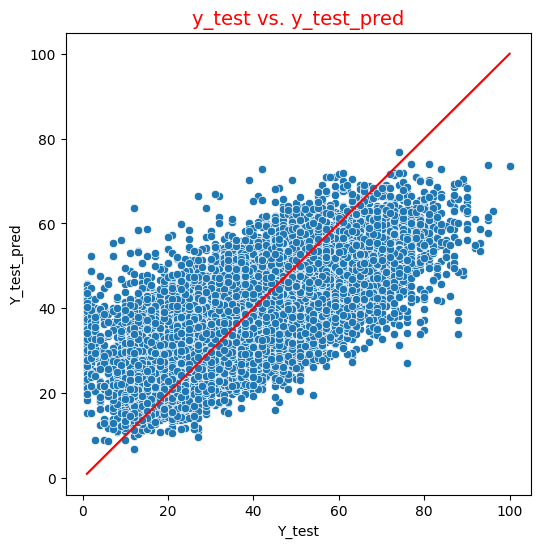

In [96]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_kn)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [97]:
knn_rmse = np.sqrt(mse(y_test, y_pred_kn))
print(f"RMSE Test = {knn_rmse:.6f}")
print('Run time = ', elapsed_4)

RMSE Test = 12.438452
Run time =  0.021403783000096155


### Polynomial

In [98]:
# Count time
start_time = timeit.default_timer()
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train_preprocessed)
pol_reg = LinearRegression()
model_log = sm.OLS(y_train, X_poly).fit()
elapsed_5 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
X_poly_test = poly.transform(X_test_preprocessed)
y_test_pred = model_log.predict(X_poly_test)#.clip(0, 1)
elapsed_5_predict = timeit.default_timer() - start_time

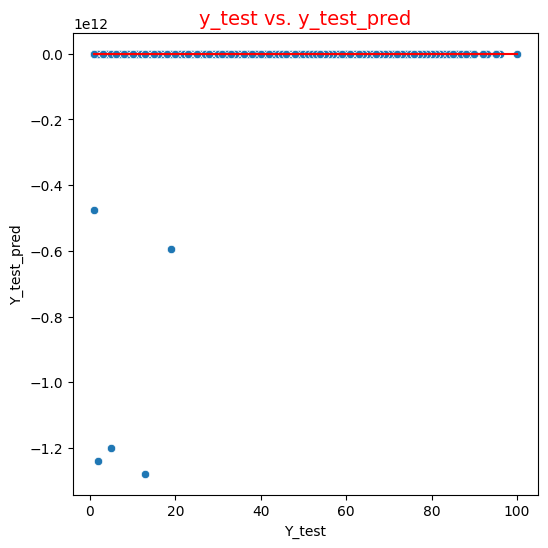

In [99]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [100]:
poly_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Test = {poly_rmse:.6f}")
print('Run Time = ', elapsed_5)

RMSE Test = 20312467031.312595
Run Time =  7.737265006999905


## Model Comparison

Comparing Linear, Lasso, Polinomial, XGboost, KNN, the RMSE of XGboost is the highest. We may use XGboost regression for the final model.

In [101]:
rmse = [LR_rmse2,lasso_rmse,xgboost_rmse,knn_rmse,poly_rmse]
time = [elapsed_1, elapsed_2,elapsed_3,elapsed_4,elapsed_5]
time_predict = [elapsed_1_predict, elapsed_2_predict,elapsed_3_predict,elapsed_4_predict,elapsed_5_predict]
name = ['Linear Regression','Lasso Regression','XGboost Regression','K-Nearest-Neighbors Regression','Polynomial Regresson']
r2_df = pd.DataFrame([name,rmse,time,time_predict]).T
r2_df.columns = ['Method','RMSE Score','Fitting Time(s)','Predicting Time(s)']
r2_df

,Method,RMSE Score,Fitting Time(s),Predicting Time(s)
0,Linear Regression,9.97476,0.115231,0.003352
1,Lasso Regression,11.831564,0.028169,0.002905
2,XGboost Regression,20.308772,20.708873,0.05833
3,K-Nearest-Neighbors Regression,12.438452,0.021404,1.142314
4,Polynomial Regresson,20312467031.312595,7.737265,0.118622


In [113]:
# export model
joblib.dump(LR, 'Popularity Prediction Model.sav')

['Popularity Prediction Model.sav']